# 3.1 Modèle sous XGBoost

## Préparation

Importation des librairies

In [28]:
import matplotlib.pyplot as plt, seaborn as sns, numpy as np, pandas as pd, warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, mean_absolute_error, mean_squared_error, f1_score
from xgboost import XGBClassifier, plot_importance
from imblearn.over_sampling import SMOTENC
warnings.filterwarnings('ignore')

Importation du dataset

In [29]:
df = pd.read_pickle('./Datasets/complete_dataset_with_scaling.pkl')

Séparation en jeu de train et test

In [30]:
X = df.drop('Attrition', axis=1)
y = df['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Ajout de valeurs synthétiques via SMOTE-NC

In [31]:
# SMOTE
sm = SMOTENC(categorical_features=[0,1,3,4,5,6,17,18,19,20,21], random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
X_train

,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,hrs,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,Travel_Rarely,Human Resources,0.347126,BAC+3,Human Resources,2,Laboratory Technician,-0.466801,-0.277692,-1.150723,...,0.156362,2.776278,-0.368619,1.928457,1.473305,Importante,Excellent,Faible,Moyen,Très satisfaisant
1,Travel_Rarely,Research & Development,0.223671,BAC+3,Life Sciences,2,Sales Executive,0.106618,-0.678721,1.309108,...,-0.619989,2.122844,2.114561,1.367694,-1.113891,Importante,Au delà des attentes,Très élevé,Élevé,Très satisfaisant
2,Travel_Rarely,Research & Development,-0.146696,BAC+2,Life Sciences,5,Laboratory Technician,-0.249458,2.128485,1.309108,...,0.156362,-0.817607,-0.058222,-0.594976,-0.405734,Très importante,Au delà des attentes,Faible,Faible,Très satisfaisant
3,Travel_Rarely,Sales,0.100215,BAC+2,Life Sciences,2,Research Scientist,1.007217,0.123338,-0.877408,...,0.156362,-0.000815,-0.368619,0.806931,-0.400310,Importante,Excellent,Très élevé,Très élevé,Satisfaisant
4,Travel_Rarely,Research & Development,-0.887430,BAC+2,Life Sciences,2,Research Scientist,-0.939727,-1.079751,-0.604094,...,2.485416,-0.000815,1.493766,0.526550,0.095741,Très importante,Excellent,Élevé,Faible,Satisfaisant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5889,Travel_Rarely,Research & Development,-0.887430,BAC+5,Life Sciences,2,Research Scientist,-0.531812,0.524367,-0.877408,...,1.709065,-0.327532,-0.679016,-0.875357,1.455746,Moyenne,Excellent,Faible,Faible,Très satisfaisant
5890,Travel_Rarely,Sales,-0.756756,BAC,Other,1,Laboratory Technician,-0.083541,-0.560791,-0.797036,...,-0.848289,-0.788812,-0.368619,-0.957808,1.872822,Moyenne,Excellent,Très élevé,Moyen,Très satisfaisant
5891,Travel_Rarely,Research & Development,0.100215,BAC+3,Medical,1,Sales Executive,-0.442156,0.524367,-1.150723,...,-0.619989,0.325902,0.252176,0.806931,-0.812567,Importante,Excellent,Très élevé,Très élevé,Excellent
5892,Travel_Rarely,Sales,0.427821,BAC+3,Life Sciences,2,Laboratory Technician,-0.337197,0.831300,-1.150723,...,-0.619989,-0.904306,-0.606186,-1.024163,0.937113,Importante,Excellent,Faible,Faible,Excellent


Suppression des variables trop corrélées [jugé non nécessaire après tests]

In [32]:
# Do a triangle correlation so we do not have duplicates
corr = X_train.corr()
triangle_mask = np.triu(np.ones_like(corr, dtype=bool))
# Get the correlation values
new_correlation = corr.mask(triangle_mask).stack().reset_index()
# Rename the columns
new_correlation.columns = ['Variable 1', 'Variable 2', 'Taux de correlation']
# Drop NA Corr if there are
new_correlation.dropna(subset = ["Taux de correlation"], inplace=True)
# Drop the rows where the correlation is 1 (because it means the variable is correlated with itself)
# Round up the values and set them to absolute
new_correlation['Taux de correlation'] = new_correlation['Taux de correlation'].round(2)
new_correlation['Taux de correlation'] = new_correlation['Taux de correlation'].abs()
# Sort the correlations by descending order
new_correlation.sort_values(by='Taux de correlation', ascending=False, inplace=True)

# Get the list of unique variables sin the "Variable 2" column where correlation >= 0.5
unique_variables = new_correlation[new_correlation['Taux de correlation'] >= 0.6]['Variable 2'].unique()
#X_train
X_train = X_train.drop(columns=unique_variables)
X_test = X_test.drop(columns=unique_variables)

Matrice de corrélation

In [33]:
# Fonction de génération de graphiques de corrélation
def plot_correlation_map( df, Size=25 ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( Size , Size ) )
    triangle_mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr,
        cmap = cmap,
        square=True,
        cbar_kws={ 'shrink' : .9 },
        ax=ax,
        mask=triangle_mask,
        annot = True,
        annot_kws = { 'fontsize' : 12 }
    )

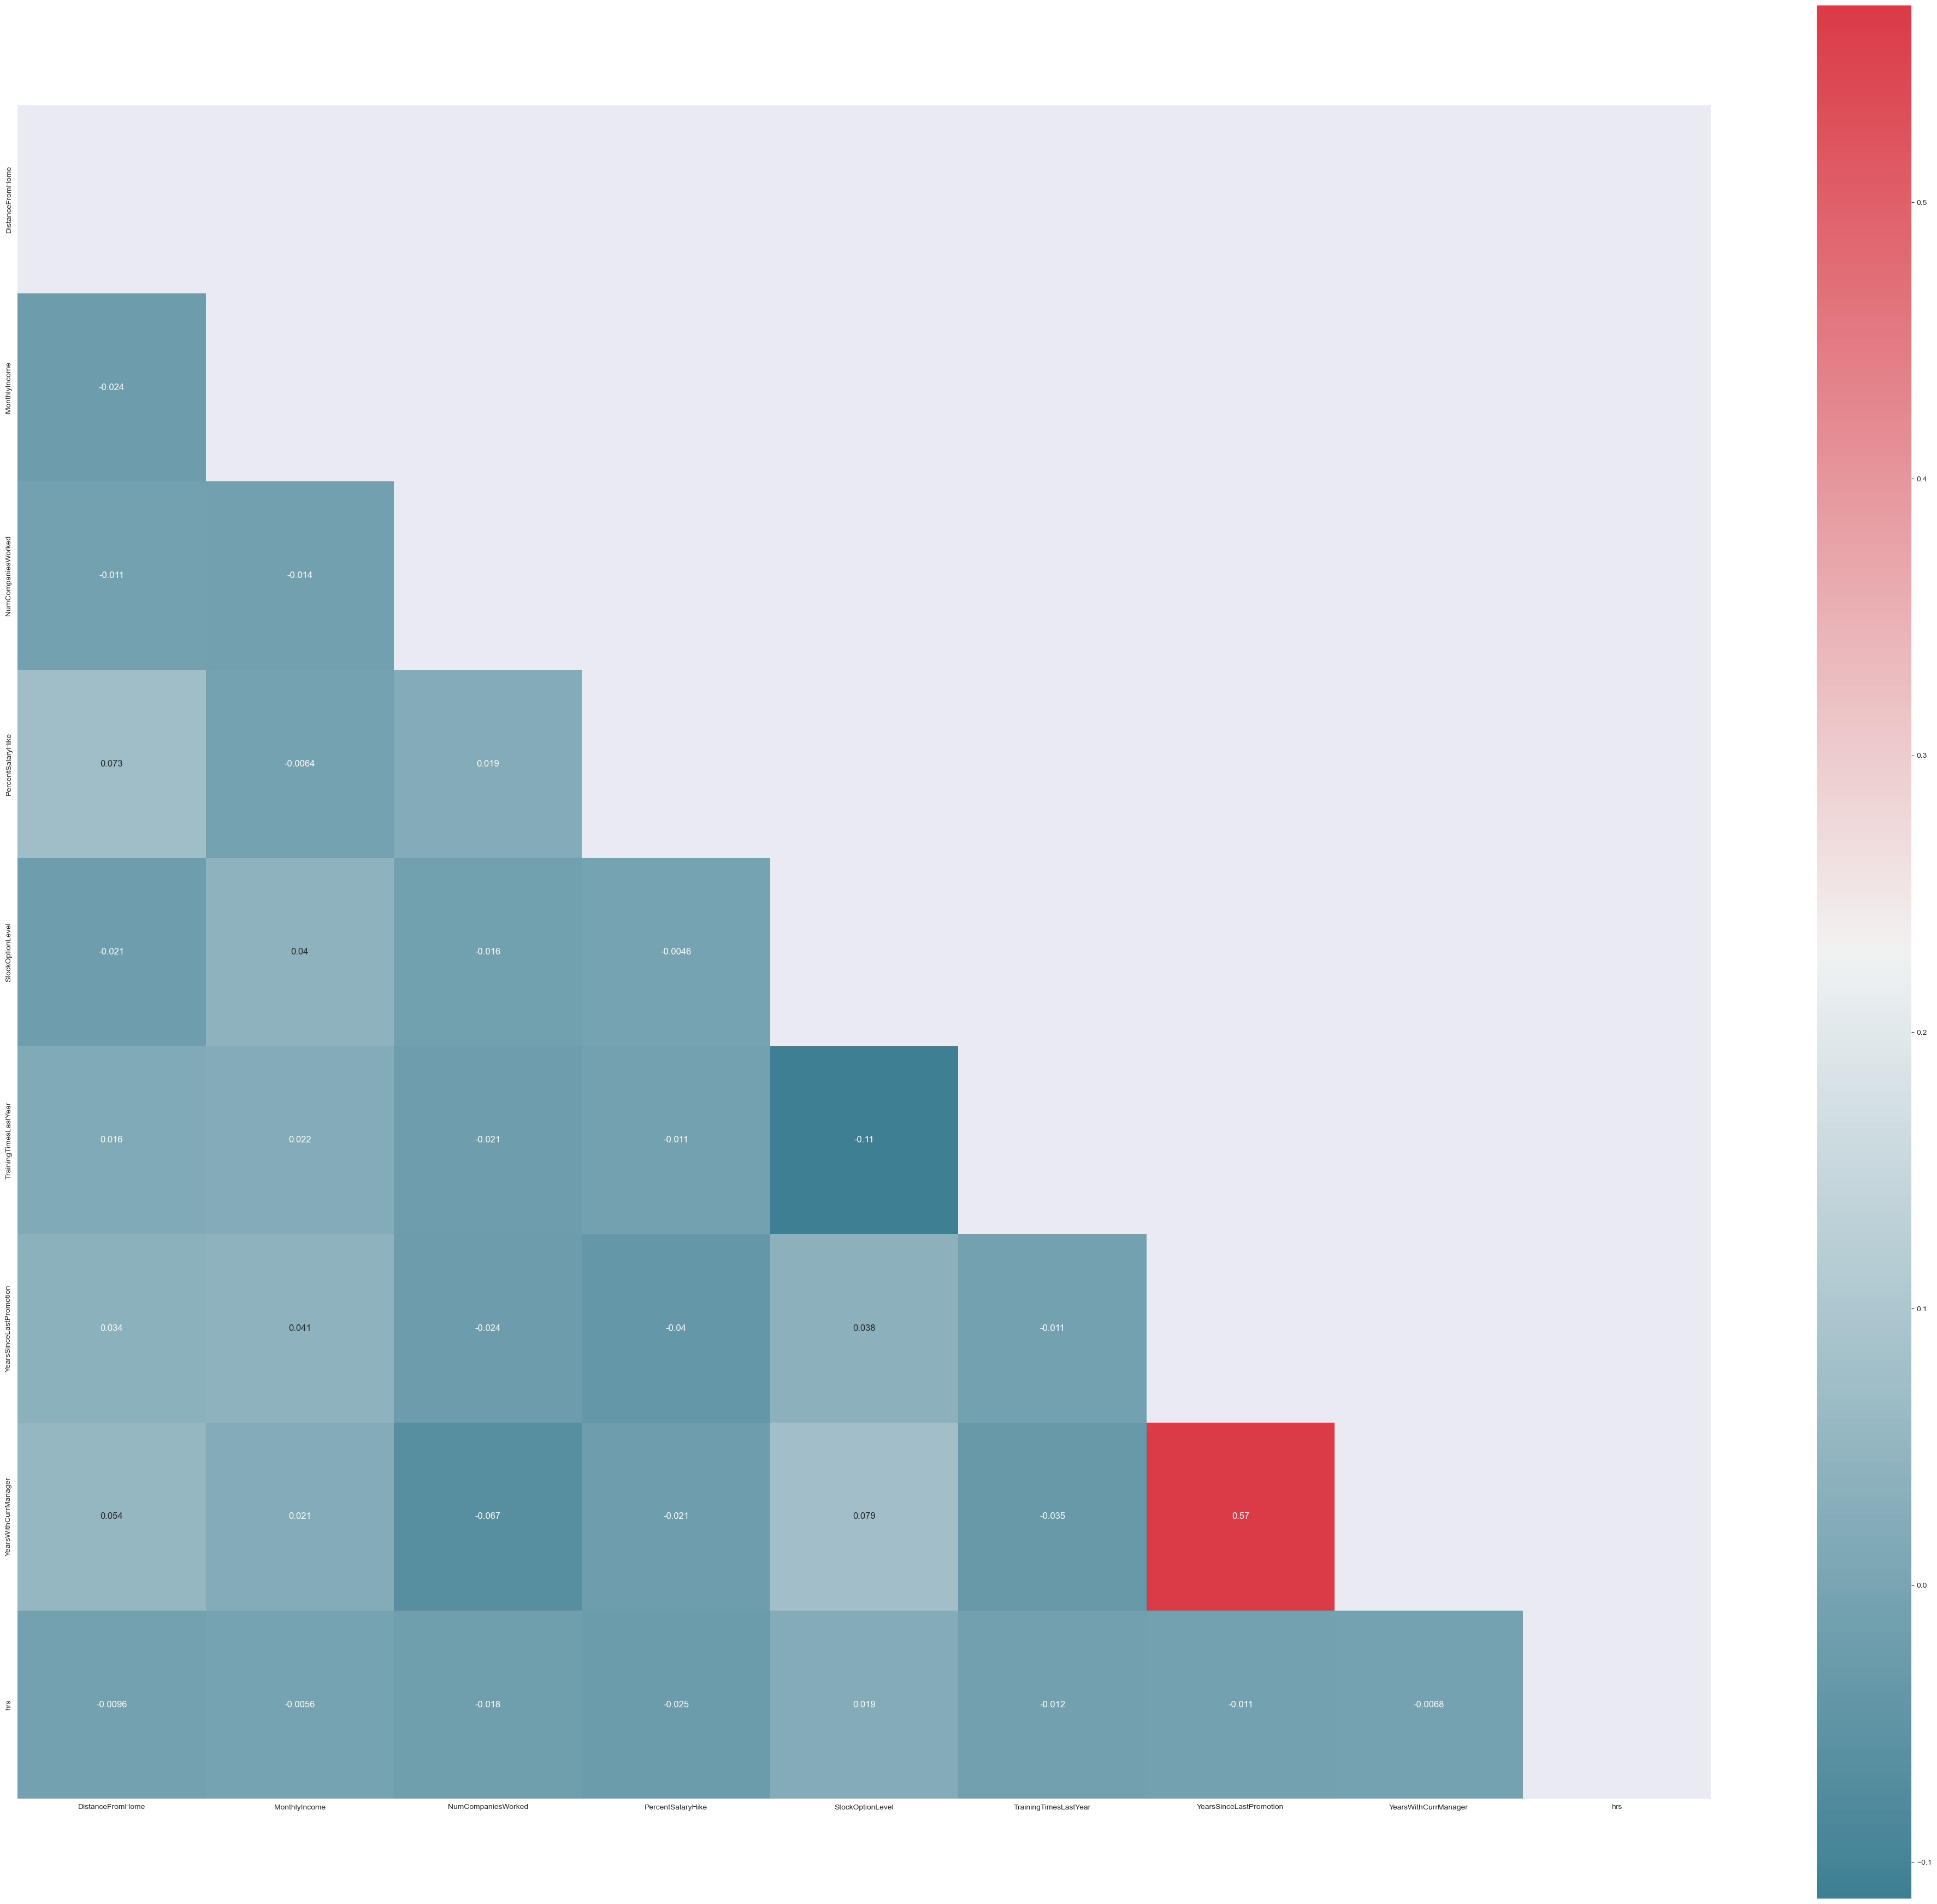

In [34]:
# Plot the matrix
plot_correlation_map(X_train,50)

Vérification de la forme des sets

In [35]:
X_train

,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TrainingTimesLastYear,YearsSinceLastPromotion,YearsWithCurrManager,hrs,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,Travel_Rarely,Human Resources,0.347126,BAC+3,Human Resources,2,Laboratory Technician,-0.466801,-0.277692,-1.150723,1.415759,0.156362,-0.368619,1.928457,1.473305,Importante,Excellent,Faible,Moyen,Très satisfaisant
1,Travel_Rarely,Research & Development,0.223671,BAC+3,Life Sciences,2,Sales Executive,0.106618,-0.678721,1.309108,1.415759,-0.619989,2.114561,1.367694,-1.113891,Importante,Au delà des attentes,Très élevé,Élevé,Très satisfaisant
2,Travel_Rarely,Research & Development,-0.146696,BAC+2,Life Sciences,5,Laboratory Technician,-0.249458,2.128485,1.309108,-0.932212,0.156362,-0.058222,-0.594976,-0.405734,Très importante,Au delà des attentes,Faible,Faible,Très satisfaisant
3,Travel_Rarely,Sales,0.100215,BAC+2,Life Sciences,2,Research Scientist,1.007217,0.123338,-0.877408,0.241773,0.156362,-0.368619,0.806931,-0.400310,Importante,Excellent,Très élevé,Très élevé,Satisfaisant
4,Travel_Rarely,Research & Development,-0.887430,BAC+2,Life Sciences,2,Research Scientist,-0.939727,-1.079751,-0.604094,-0.932212,2.485416,1.493766,0.526550,0.095741,Très importante,Excellent,Élevé,Faible,Satisfaisant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5889,Travel_Rarely,Research & Development,-0.887430,BAC+5,Life Sciences,2,Research Scientist,-0.531812,0.524367,-0.877408,-0.932212,1.709065,-0.679016,-0.875357,1.455746,Moyenne,Excellent,Faible,Faible,Très satisfaisant
5890,Travel_Rarely,Sales,-0.756756,BAC,Other,1,Laboratory Technician,-0.083541,-0.560791,-0.797036,2.589744,-0.848289,-0.368619,-0.957808,1.872822,Moyenne,Excellent,Très élevé,Moyen,Très satisfaisant
5891,Travel_Rarely,Research & Development,0.100215,BAC+3,Medical,1,Sales Executive,-0.442156,0.524367,-1.150723,0.241773,-0.619989,0.252176,0.806931,-0.812567,Importante,Excellent,Très élevé,Très élevé,Excellent
5892,Travel_Rarely,Sales,0.427821,BAC+3,Life Sciences,2,Laboratory Technician,-0.337197,0.831300,-1.150723,0.241773,-0.619989,-0.606186,-1.024163,0.937113,Importante,Excellent,Faible,Faible,Excellent


In [36]:
X_test

,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TrainingTimesLastYear,YearsSinceLastPromotion,YearsWithCurrManager,hrs,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
2983,Travel_Rarely,Sales,-0.270152,BAC+3,Life Sciences,1,Research Scientist,-0.571754,-0.678721,-0.057465,-0.932212,0.156362,-0.679016,-1.155739,-0.345407,Importante,Excellent,Très élevé,Élevé,Très satisfaisant
1499,Travel_Rarely,Sales,-0.887430,BAC+3,Marketing,1,Manager,-0.436632,2.529514,-0.877408,-0.932212,0.156362,-0.368619,-0.594976,1.612522,Moyenne,Excellent,Très élevé,Très élevé,Très satisfaisant
4112,Travel_Rarely,Sales,1.334772,BAC+5,Medical,2,Research Director,-0.950562,0.123338,-1.150723,0.241773,0.156362,-0.368619,1.928457,0.177650,Moyenne,Excellent,Moyen,Élevé,Très satisfaisant
478,Travel_Rarely,Sales,-0.763975,BAC+3,Medical,1,Research Director,-0.231187,1.727455,-1.150723,0.241773,-1.396341,0.562573,1.087313,-0.544639,Importante,Excellent,Élevé,Élevé,Très satisfaisant
530,Travel_Rarely,Research & Development,-1.010886,BAC+3,Life Sciences,2,Healthcare Representative,0.202647,0.123338,-1.150723,1.415759,-1.396341,-0.368619,0.806931,-0.994342,Très importante,Excellent,Élevé,Élevé,Excellent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2662,Travel_Rarely,Research & Development,0.840949,BAC+3,Medical,2,Healthcare Representative,-0.873016,-0.678721,0.215850,0.241773,0.156362,-0.368619,0.806931,-0.405272,Importante,Excellent,Élevé,Très élevé,Très satisfaisant
1727,Non-Travel,Research & Development,-0.887430,BAC,Medical,1,Research Scientist,2.599785,-0.678721,1.035793,0.241773,-0.619989,-0.679016,-1.155739,-0.353551,Très importante,Excellent,Élevé,Élevé,Très satisfaisant
321,Travel_Rarely,Sales,-0.887430,BAC+3,Marketing,1,Sales Representative,0.809209,-0.678721,-0.877408,-0.932212,-0.619989,-0.368619,-0.314594,0.246651,Importante,Excellent,Élevé,Faible,Très satisfaisant
897,Travel_Rarely,Sales,-0.887430,BAC+5,Life Sciences,1,Laboratory Technician,0.161644,-1.079751,0.489164,-0.932212,1.709065,-0.679016,0.806931,-0.230276,Importante,Excellent,Élevé,Élevé,Très satisfaisant


## Création du modèle

[0]	validation_0-auc:0.85832	validation_0-error:0.23142	validation_1-auc:0.70118	validation_1-error:0.36508
[1]	validation_0-auc:0.87263	validation_0-error:0.20886	validation_1-auc:0.69691	validation_1-error:0.24830
[2]	validation_0-auc:0.89636	validation_0-error:0.19647	validation_1-auc:0.73370	validation_1-error:0.24263
[3]	validation_0-auc:0.92315	validation_0-error:0.15287	validation_1-auc:0.75287	validation_1-error:0.21769
[4]	validation_0-auc:0.93165	validation_0-error:0.13709	validation_1-auc:0.76950	validation_1-error:0.21655
[5]	validation_0-auc:0.93837	validation_0-error:0.13098	validation_1-auc:0.77790	validation_1-error:0.20181
[6]	validation_0-auc:0.94502	validation_0-error:0.12640	validation_1-auc:0.78870	validation_1-error:0.19161
[7]	validation_0-auc:0.95204	validation_0-error:0.12267	validation_1-auc:0.79244	validation_1-error:0.19048
[8]	validation_0-auc:0.96057	validation_0-error:0.11181	validation_1-auc:0.80585	validation_1-error:0.18367
[9]	validation_0-auc:0.96766

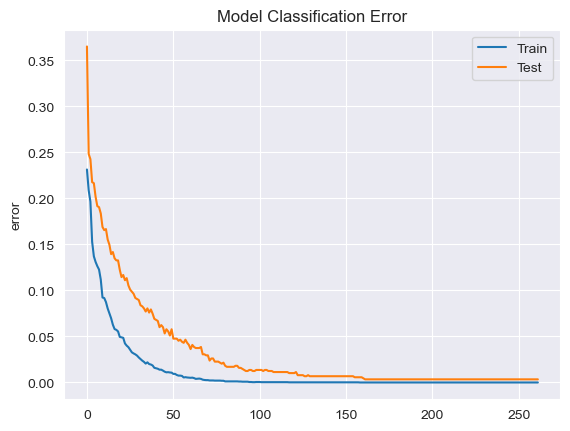

In [37]:
# Modification du type des colonnes pour que le modèle puisse se servir des "catégories"
for col in X_train.select_dtypes(include=['object']).columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# XGBClassifier Model

## Try except en cas d'erreur de GPU (absence de GPU ou GPU AMD)
try:
    xgb = XGBClassifier(n_estimators=1000, enable_categorical=True, tree_method="gpu_hist", learning_rate=0.15, early_stopping_rounds=100)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    eval_metric = ["auc","error"]
    xgb.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)
except:
    print("GPU Nvidia non détecté. Merci de lancer ce notebook sur un équipement possédant un GPU Nvidia récent.")

# Prédictions
xgb_pred = xgb.predict(X_train)


# Graph d'erreurs
results = xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('error')
plt.title('Model Classification Error')
plt.show()

Vérification de la précision sur le set de train

In [38]:
accuracy_score(y_train, xgb_pred)

1.0

Le modèle peut avoir overfit. Vérifions##

## Vérification du modèle sur le set de train

Matrice de confusion

In [39]:
confusion_matrix(y_train, xgb_pred)

array([[2947,    0],
       [   0, 2947]], dtype=int64)

Précision et Recall du modèle sur le set de train

In [40]:
print('Precision: %.3f' % precision_score(y_train, xgb_pred))
print('Recall: %.3f' % recall_score(y_train, xgb_pred))

Precision: 1.000
Recall: 1.000


## Vérification du modèle sur le set de test

Vérification de la précision sur le set de test

In [41]:
test_inference = xgb.predict(X_test)
accuracy_score(y_test, test_inference)

0.9965986394557823

MAE & RMSE

In [42]:
print('MAE: %.3f' % mean_absolute_error(y_test, test_inference))
print('RMSE: %.3f' % mean_squared_error(y_test, test_inference))

MAE: 0.003
RMSE: 0.003


Courbe ROC et AUC

No Skill: ROC AUC=0.500
XGB: ROC AUC=0.991


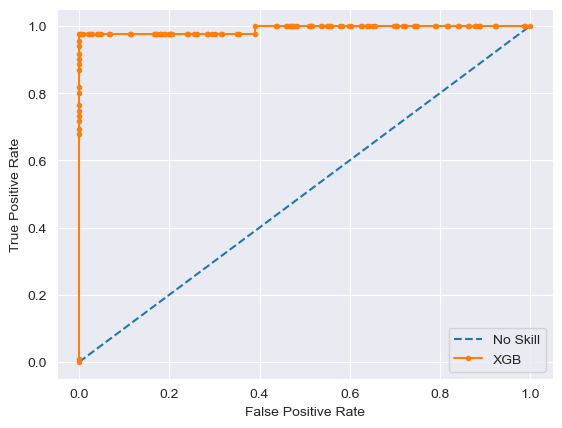

In [43]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
xgb_probs = xgb.predict_proba(X_test)
# keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGB: ROC AUC=%.3f' % (xgb_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGB')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Matrice de confusion

In [44]:
confusion_matrix(y_test, test_inference)

array([[751,   0],
       [  3, 128]], dtype=int64)

F1 Score

In [45]:
print('F1 Score: %.3f' % f1_score(y_test, test_inference))

F1 Score: 0.988


## Fine tuning du modèle

In [46]:
# Opération pouvant être longue en fonction du hardware.
from xgbtune import tune_xgb_model
params = {'enable_categorical':'True', 'tree_method':"gpu_hist", 'n_estimators':1000}
params, round_count = tune_xgb_model(params, X_train, y_train)

tuning pass 0...
computing best round...
[14:31:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "enable_categorical", "n_estimators" } are not used.

[14:31:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "enable_categorical", "n_estimators" } are not used.

[14:31:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "enable_categorical", "n_estimators" } are not used.

best round: 406
tuning max_depth and min_child_weight ...
[14:31:14] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "enable_categorical", "n_estimators" } are not used.

[14:3

Conclusion du fine tuner s'il a été lancé :

best loss: 0.0009
best seed: 0
{'enable_categorical': 'True', 'tree_method': 'gpu_hist', 'n_estimators': 1000, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.0, 'subsample': 0.8, 'colsample_bytree': 1.0, 'alpha': 0, 'lambda': 1, 'seed': 0}

[0]	validation_0-auc:0.91213	validation_0-error:0.16322	validation_1-auc:0.72711	validation_1-error:0.28345
[1]	validation_0-auc:0.94649	validation_0-error:0.12691	validation_1-auc:0.78246	validation_1-error:0.22336
[2]	validation_0-auc:0.96742	validation_0-error:0.09552	validation_1-auc:0.81406	validation_1-error:0.19161
[3]	validation_0-auc:0.98075	validation_0-error:0.07329	validation_1-auc:0.85669	validation_1-error:0.15873
[4]	validation_0-auc:0.98617	validation_0-error:0.06430	validation_1-auc:0.88102	validation_1-error:0.14399
[5]	validation_0-auc:0.99041	validation_0-error:0.04988	validation_1-auc:0.89191	validation_1-error:0.12925
[6]	validation_0-auc:0.99376	validation_0-error:0.03631	validation_1-auc:0.90829	validation_1-error:0.10317
[7]	validation_0-auc:0.99693	validation_0-error:0.02647	validation_1-auc:0.93689	validation_1-error:0.08617
[8]	validation_0-auc:0.99832	validation_0-error:0.01612	validation_1-auc:0.94952	validation_1-error:0.07483
[9]	validation_0-auc:0.99880

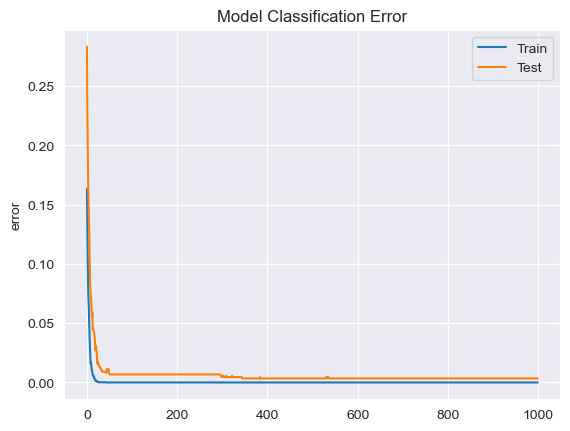

In [47]:
xgb = XGBClassifier(**params)
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]
xgb.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

# Prédictions
xgb_pred = xgb.predict(X_train)


# Graph d'erreurs
results = xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('error')
plt.title('Model Classification Error')
plt.show()

## Vérification du modèle sur le set de test

Vérification de la précision sur le set de test

In [48]:
test_inference = xgb.predict(X_test)
accuracy_score(y_test, test_inference)

0.9965986394557823

MAE & RMSE

In [49]:
print('MAE: %.3f' % mean_absolute_error(y_test, test_inference))
print('RMSE: %.3f' % mean_squared_error(y_test, test_inference))

MAE: 0.003
RMSE: 0.003


Courbe ROC & AUC

No Skill: ROC AUC=0.500
XGB: ROC AUC=0.997


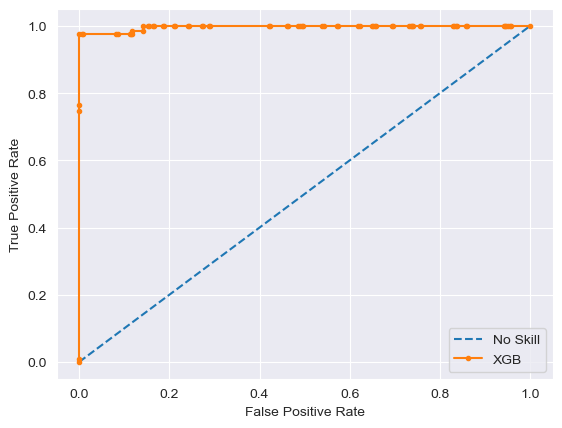

In [50]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
xgb_probs = xgb.predict_proba(X_test)
# keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGB: ROC AUC=%.3f' % (xgb_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGB')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Matrice de confusion

In [51]:
confusion_matrix(y_test, test_inference)

array([[751,   0],
       [  3, 128]], dtype=int64)

F1 Score

In [52]:
print('F1 Score: %.3f' % f1_score(y_test, test_inference))

F1 Score: 0.988


## Conclusion

Vérification du poids de chaque feature

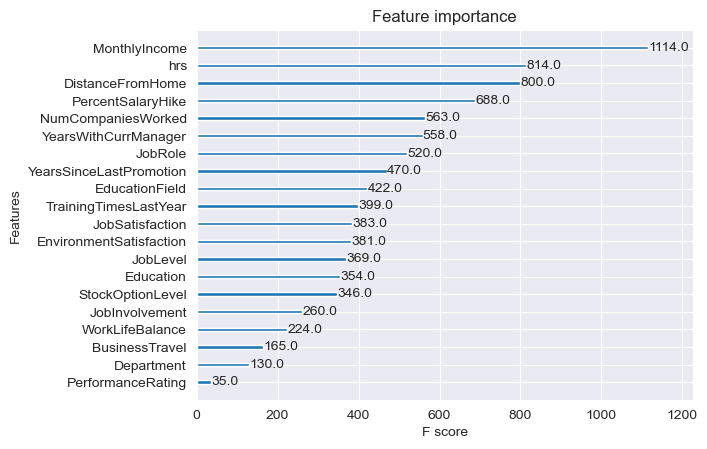

<Figure size 3200x1200 with 0 Axes>

In [53]:
plot_importance(xgb)
plt.figure(figsize = (32, 12))
plt.show()